In [1]:
# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Seminar: Monte-carlo tree search

In this seminar, we'll implement a vanilla MCTS planning and use it to solve some Gym envs.

But before we do that, we first need to modify gym env to allow saving and loading game states to facilitate backtracking.

In [3]:
from gym.core import Wrapper
from pickle import dumps
from pickle import loads
from collections import namedtuple

In [4]:
# A container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple("action_result",
                          ("snapshot", "observation", "reward", "is_done", "info"))

In [5]:
class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset, step and render directly for convenience.
    - s, r, done, _ = self.step(action)   #step, same as self.env.step(action)
    - self.render(close=True)             #close window, same as self.env.render(close=True)
    """

    def get_snapshot(self):
        """
        Returns an environment state that can be loaded with self.load_snapshot
        
        Snapshots guarantee same env behaviour each time they are loaded
        
        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.
        
        Warning
        -------
        Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.
                
        Returns
        -------
        bytes
            Environment state.
            The state can be loaded with self.load_snapshot
        """
        
        self.render() #close popup windows since we can't pickle them
        if self.unwrapped.viewer is not None:
            self.unwrapped.viewer.close()
            self.unwrapped.viewer = None
        return dumps(self.env)
    
    def load_snapshot(self, snapshot):
        """
        Loads snapshot as current env state
        
        Should not change snapshot inplace (in case of doubt, deepcopy)
        
        Parameters
        ----------
        snapshot : bytes
            A snapshot of the environment
        """
        
        assert not hasattr(self,"_monitor") or hasattr(self.env,"_monitor"), "can't backtrack while recording"

        # Close popup windows since we can't load into them
        self.close() 
        self.env = loads(snapshot)
    
    def get_result(self, snapshot, action):
        """
        Return next snapshot and everything that env.step would have returned
        
        The function 
        1. Loads the snapshot
        2. Commits action via self.step
        3. Takes a snapshot of the state
        
        Parameters
        ----------
        snapshot : bytes
            A snapshot of the environment
        action : int
            The action to be taken
                
        Returns
        -------
        namedtuple
            A named tuple containing:
            - next_snapshot
            - next_observation
            - reward
            - is_done 
            - info
        """
        
        self.load_snapshot(snapshot)
        next_observation, reward, is_done, info = self.step(action)
        next_snapshot = self.get_snapshot()
        
        return ActionResult(next_snapshot,
                            next_observation, 
                            reward, 
                            is_done, 
                            info)

### Try out snapshots:

In [6]:
#make env
env = WithSnapshots(gym.make("CartPole-v0"))
env.reset()

n_actions = env.action_space.n

/usr/local/lib/python3.5/dist-packages/gym/logger.py:30: UserWarning: WARN: <class '__main__.WithSnapshots'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


initial_state:


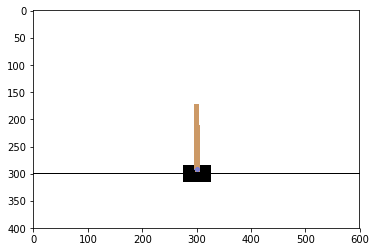

In [7]:
print("initial_state:")

plt.imshow(env.render('rgb_array'))

# Create first snapshot
snap0 = env.get_snapshot()

Whoops! We died!
final state:


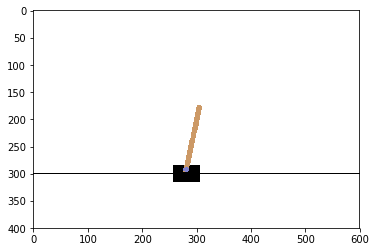

In [8]:
# Play without making snapshots (faster)
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done: 
        print("Whoops! We died!")
        break
        
print("final state:")
plt.imshow(env.render('rgb_array'))
plt.show()



After loading snapshot


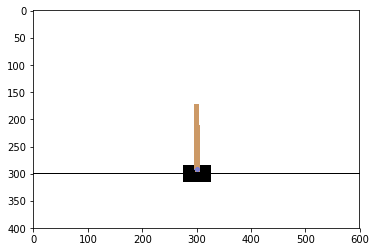

In [9]:
# Reload initial state
env.load_snapshot(snap0)

print("\n\nAfter loading snapshot")
plt.imshow(env.render('rgb_array'))
plt.show()

In [10]:
# Get outcome (snapshot, observation, reward, is_done, info)
res = env.get_result(snap0, env.action_space.sample())

snap1, observation, reward = res[:3]

# Second step
res2 = env.get_result(snap1, env.action_space.sample())

# MCTS: Monte-Carlo tree search

In this section, we'll implement the vanilla MCTS algorithm with UCB1-based node selection.

We will start by implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [11]:
assert isinstance(env, WithSnapshots)

In [ ]:
class Node:
    """ 
    A tree node for Monte Carlo Tree Search (MCTS) 
    """
    
    # Class variables
    parent = None  # parent Node
    value_sum = 0.  # sum of state values from all visits (numerator)
    times_visited = 0  # counter of visits (denominator)

    
    def __init__(self, parent, action):
        """
        Creates and empty node with no children.
        Does so by commiting an action and recording outcome.
        
        Parameters
        ----------
        parent : Node
            The parent node
        action : int
            The action to commit from parent Node
        """
        
        self.parent = parent
        self.action = action        
        # Set of child nodes
        self.children = set()       

        # Get action outcome and save it
        res = env.get_result(parent.snapshot, action)
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res
        
    def is_leaf(self):
        """
        Check if node has no children
        
        Returns
        -------
        bool
            True if self.children is empty
        """
        return len(self.children)==0
    
    def is_root(self):
        """
        Check if node has no parents
        
        Returns
        -------
        bool
            True if self.parent is None
        """
        return self.parent is None
    
    def get_mean_value(self):
        """
        Returns the mean value of the node (value of all visits/times node visited)
        
        Returns
        -------
        float
            The mean value
        """
        return self.value_sum / self.times_visited if self.times_visited !=0 else 0
    
    def ucb_score(self,scale=10,max_value=1e100):
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent
        
        Parameters
        ----------
        scale : float
            Scale to multiply upper bound by
            From Hoeffding inequality, this assumes that the reward is in the range [0,scale]
        max_value : float
            A value that represents infinity (for unvisited nodes)
        """
        
        if self.times_visited == 0:
            return max_value
        
        # compute ucb-1 additive component (to be added to mean value)
        # hint: you can use self.parent.times_visited for N times node was considered,
        # and self.times_visited for n times it was visited
        
        U = <your code here>
        
        return self.get_mean_value() + scale*U
    
    
    #MCTS steps
    
    def select_best_leaf(self):
        """
        Picks the leaf with highest priority to expand.
        Does so by recursively picking nodes with best UCB-1 score until it reaches the leaf
        
        Returns
        -------
        Node
            Selevt the best leaf node
        """
        if self.is_leaf():
            return self
        
        children = self.children
        
        best_child = <select best child node in terms of node.ucb_score()>
        
        return best_child.select_best_leaf()
    
    def expand(self):
        """
        Expands the current node by creating all possible child nodes.
        Then returns one of those children
        
        Returns
        -------
        Node
            Best leaf of the current node
        """
        
        assert not self.is_done, "can't expand from terminal state"

        for action in range(n_actions):
            self.children.add(Node(self, action))
        
        return self.select_best_leaf()
    
    def rollout(self, t_max=10**4):
        """
        Play the game from this state to the end (done) or for t_max steps
        
        On each step, we pick action at random
        
        Notes
        -----
        If node is terminal (self.is_done is True), we return 0
        
        Parameters
        ----------
        t_max : int
            How many steps
        
        Returns
        -------
        rollout_reward : float
            The sum of the rewards in the rollouts
        """
        
        # hint for random pick (hint: env.action_space.sample())
            
        # Set env into the appropriate state
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done
        
        <your code here - rollout and compute reward>

        return rollout_reward
    
    def propagate(self, child_value):
        """
        Uses child value (sum of rewards) to update parents recursively.
        """
        # Compute node value
        my_value = self.immediate_reward + child_value
        
        # Update value_sum and times_visited
        self.value_sum += my_value
        self.times_visited += 1
        
        # Propagate upwards
        if not self.is_root():
            self.parent.propagate(my_value)
        
    def safe_delete(self):
        """
        Safe delete to prevent memory leak in some python versions
        """
        
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [ ]:
class Root(Node):
    def __init__(self,snapshot,observation):
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """
        
        self.parent = self.action = None
        self.children = set()       #set of child nodes
        
        #root: load snapshot and observation
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done=False
    
    @staticmethod
    def from_node(node):
        """initializes node as root"""
        root = Root(node.snapshot,node.observation)
        #copy data
        copied_fields = ["value_sum","times_visited","children","is_done"]
        for field in copied_fields:
            setattr(root,field,getattr(node,field))
        return root

## Main MCTS loop

With all we implemented, MCTS boils down to a trivial piece of code.

In [ ]:
def plan_mcts(root,n_iters=10):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    for _ in range(n_iters):

        node = <select best leaf>

        if node.is_done:
            node.propagate(0)

        else: #node is not terminal
            <expand-simulate-propagate loop>
    


## Plan and execute
In this section, we use the MCTS implementation to find optimal policy.

In [ ]:
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot,root_observation)

In [ ]:
#plan from root:
plan_mcts(root,n_iters=1000)

In [ ]:
from IPython.display import clear_output
from itertools import count
from gym.wrappers import Monitor

total_reward = 0                #sum of rewards
test_env = loads(root_snapshot) #env used to show progress

for i in count():
    
    #get best child
    best_child = <select child with highest mean reward>
    
    #take action
    s,r,done,_ = test_env.step(best_child.action)
    
    #show image
    clear_output(True)
    plt.title("step %i"%i)
    plt.imshow(test_env.render('rgb_array'))
    plt.show()

    total_reward += r
    if done:
        print("Finished with reward = ",total_reward)
        break
    
    #discard unrealized part of the tree [because not every child matters :(]
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    #declare best child a new root
    root = Root.from_node(best_child)
    
    assert not root.is_leaf(), "We ran out of tree! Need more planning! Try growing tree right inside the loop."
    
    #you may want to expand tree here
    #<your code here>


### Submit to Coursera

In [ ]:
from submit import submit_mcts

submit_mcts(total_reward, <EMAIL>, <TOKEN>)

## More stuff

There's a few things you might want to try if you want to dig deeper:

### Node selection and expansion

"Analyze this" assignment

UCB-1 is a weak bound as it relies on a very general bounds (Hoeffding Inequality, to be exact). 
* Try playing with alpha. The theoretically optimal alpha for CartPole is 200 (max reward). 
* Use using a different exploration strategy (bayesian UCB, for example)
* Expand not all but several random actions per `expand` call. See __the notes below__ for details.

The goal is to find out what gives the optimal performance for `CartPole-v0` for different time budgets (i.e. different n_iter in plan_mcts.

Evaluate your results on `AcroBot-v1` - do the results change and if so, how can you explain it?


### Atari-RAM

"Build this" assignment

Apply MCTS to play atari games. In particular, let's start with ```gym.make("MsPacman-ramDeterministic-v0")```.

This requires two things:
* Slightly modify WithSnapshots wrapper to work with atari.

 * Atari has a special interface for snapshots:
   ```   
   snapshot = self.env.ale.cloneState()
   ...
   self.env.ale.restoreState(snapshot)
   ```
 * Try it on the env above to make sure it does what you told it to.
 
* Run MCTS on the game above. 
 * Start with small tree size to speed-up computations
 * You will probably want to rollout for 10-100 steps (t_max) for starters
 * Consider using discounted rewards (see __notes at the end__)
 * Try a better rollout policy
 
 
### Integrate learning into planning

Planning on each iteration is a costly thing to do. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

To do so, just record which action did the MCTS agent take on each step and fit something to [state, mcts_optimal_action]
* You can also use optimal actions from discarded states to get more (dirty) samples. Just don't forget to fine-tune without them.
* It's also worth a try to use P(best_action|state) from your model to select best nodes in addition to UCB
* If your model is lightweight enough, try using it as a rollout policy.

While CartPole is glorious enough, try expanding this to ```gym.make("MsPacmanDeterministic-v0")```
* See previous section on how to wrap atari

* Also consider what [AlphaGo Zero](https://deepmind.com/blog/alphago-zero-learning-scratch/) did in this area.

### Integrate planning into learning 
_(this will likely take long time, better consider this as side project when all other deadlines are met)_

Incorporate planning into the agent architecture. 

The goal is to implement [Value Iteration Networks](https://arxiv.org/abs/1602.02867)

For starters, remember [week7 assignment](https://github.com/yandexdataschool/Practical_RL/blob/master/week7/7.2_seminar_kung_fu.ipynb)? If not, use [this](http://bit.ly/2oZ34Ap) instead.

You will need to switch it into a maze-like game, consider MsPacman or the games from week7 [Bonus: Neural Maps from here](https://github.com/yandexdataschool/Practical_RL/blob/master/week7/7.3_homework.ipynb).

You will need to implement a special layer that performs value iteration-like update to a recurrent memory. This can be implemented the same way you did attention from week7 or week8.

## Notes


#### Assumptions

The full list of assumptions is
* __Finite actions__ - we enumerate all actions in `expand`
* __Episodic (finite) MDP__ - while technically it works for infinite mdp, we rollout for $ 10^4$ steps. If you are knowingly infinite, please adjust `t_max` to something more reasonable.
* __No discounted rewards__ - we assume $\gamma=1$. If that isn't the case, you only need to change a two lines in `rollout` and use `my_R = r + gamma*child_R` for `propagate`
* __pickleable env__ - won't work if e.g. your env is connected to a web-browser surfing the internet. For custom envs, you may need to modify get_snapshot/load_snapshot from `WithSnapshots`.

#### On `get_best_leaf` and `expand` functions

This MCTS implementation only selects leaf nodes for expansion.
This doesn't break things down because `expand` adds all possible actions. Hence, all non-leaf nodes are by design fully expanded and shouldn't be selected.

If you want to only add a few random action on each expand, you will also have to modify `get_best_leaf` to consider returning non-leafs.

#### Rollout policy

We use a simple uniform policy for rollouts. This introduces a negative bias to good situations that can be messed up completely with random bad action. As a simple example, if you tend to rollout with uniform policy, you better don't use sharp knives and walk near cliffs.

You can improve that by integrating a reinforcement _learning_ algorithm with a computationally light agent. You can even train this agent on optimal policy found by the tree search.

#### Contributions
* Reusing some code from 5vision [solution for deephack.RL](https://github.com/5vision/uct_atari), code by Mikhail Pavlov
* Using some code from [this gist](https://gist.github.com/blole/dfebbec182e6b72ec16b66cc7e331110)